In [3]:
import tenpy
import numpy as np
import matplotlib.pylab as plt
from importlib import reload 
import tenpy.linalg.np_conserved as np_c
import tenpy.linalg.charges as charges
from math import *

In [4]:
N=100
cInfo=tenpy.linalg.charges.ChargeInfo(mod=[N])
leg0=tenpy.linalg.charges.LegCharge(cInfo,slices=[0,100],charges=[[0]],qconj=-1)
leg1=tenpy.linalg.charges.LegCharge(cInfo,slices=[0,2,4],charges=[[0],[1]],qconj=-1)
leg2=tenpy.linalg.charges.LegCharge(cInfo,slices=[0,50,100],charges=[[0],[1]],qconj=1)
T=tenpy.linalg.np_conserved.Array([leg0,leg1,leg2])
T[0:100,0:2,0:50]=np.random.random(size=(100,2,50))
T[0:100,2:4,50:100]=np.random.random(size=(100,2,50))
T2=T.combine_legs([0,1],qconj=-1)
U,S,V=np_c.svd(T2)
U=U.gauge_total_charge(1, newqtotal=None, new_qconj=1)
V=V.gauge_total_charge(0, newqtotal=None, new_qconj=-1)
S=np_c.diag(S,leg=V.legs[0])

In [5]:
def shiftOrthogonalizationCenterLeft(A,B):
    B=B.combine_legs([1,2])
    U,S,V=np_c.svd(B)
    S=np_c.diag(S,leg=U.legs[1].conj())
    U=np_c.tensordot(U,S,axes=[1,0])
    V=V.split_legs([1])
    A=np_c.tensordot(A,U,axes=[2,0])
    return A,V

def shiftOrthogonalizationCenterRight(A,B):
    A=B.combine_legs([0,1])
    U,S,V=np_c.svd(A)
    S=np_c.diag(S,leg=U.legs[1].conj())
    V=np_c.tensordot(S,V,axes=[1,0])
    U=U.split_legs([0])
    B=np_c.tensordot(V,B,axes=[1,0])
    return U,B

def shiftOrthogonalizationCenter(A,B,direction):
    if direction == "left":
        return shiftOrthogonalizationCenterLeft(A,B)
    elif direction == "right":
        return shiftOrthogonalizationCenterRight(A,B)
    else:
        raise ValueError("Unkown direction : " + str(direction))

In [14]:
def createMPSBasisState(cInfo,state,p,leftCharges=None):
    '''
    "Defined only for a single charge. Create a Tensor with shape (1,d,1). Only one charge sector is not zero
    '''
    if state>=p:
        raise ValueError("Invalid state: " + str(state))
    
    N=cInfo.mod[0]
    if leftCharges is None:
        leftCharges=[ [i] for i in range(N)]  

    slices=[ i for i in range(len(leftCharges) + 1)]
    
    rightCharges=(np.array(leftCharges) + state )%N
    
    leg0=tenpy.linalg.charges.LegCharge(cInfo,slices=slices,charges=leftCharges,qconj=1)
    leg1=tenpy.linalg.charges.LegCharge(cInfo,slices=[i for i in range(p+1)],charges=[ [i] for i in range(p)  ],qconj=1 )
    leg2=tenpy.linalg.charges.LegCharge(cInfo,slices=slices,charges=rightCharges,qconj=-1 )
    
    T=np_c.Array([leg0,leg1,leg2])
    for i in range( len(slices)-1):
            T[i,state,i]=1
    return T


def createMPSProductStateTensors(cInfo,states,p):
    '''
    Create the tensors to create an mps state
    returns:
    q : total charge of the product state
    Ts : tensors, including vector bonds at the beginning and at the end
    '''
    Ts=[]
    q=0
    leg0=charges.LegCharge(cInfo,slices=[0,1],charges=[[q]],qconj=-1)
    leftBond=np_c.Array([leg0])
    leftBond[0]=1
    
    for state in states:
        T=createMPSBasisState(cInfo,state=state,p=p,leftCharges=[[q]],)
        Ts.append(T)
        q=q + state
        
    return q,Ts

N=100
cInfo=tenpy.linalg.charges.ChargeInfo(mod=[N])
Q,Ts=createMPSProductStateTensors(cInfo,[0,1,0,1,1,0,1],p=2)
len(Ts)

7

In [7]:
A=Ts[-2]
B=Ts[-1]
A,B=shiftOrthogonalizationCenter(A,B,direction="left")

In [11]:
import mpsTen
import ten
reload(mpsTen)
reload(ten)
N=100
cInfo=tenpy.linalg.charges.ChargeInfo(mod=[N])
Q,Ts=createMPSProductStateTensors(cInfo,[0,1,0,1,1,0,1],p=2)
state=mpsTen.mps(Ts,Q)
state.normalize()

In [72]:
def operator_a(cInfo,p):
    slices=[ i for i in range(p+1)]
    chargesLeg=[ [i] for i in range(p)]
    leg0=np_c.LegCharge(cInfo,slices=slices,charges=chargesLeg)
    
    A=np_c.Array([leg0.conj(),leg0],qtotal=[[-1]])
    
    for charge in chargesLeg:
        n=charge[0]
        if n>=1:
            A[n,n-1]=np.sqrt(n)
    return A
def operator_a_dagger(cInfo,p):
    slices=[ i for i in range(p+1)]
    chargesLeg=[ [i] for i in range(p)]
    leg0=np_c.LegCharge(cInfo,slices=slices,charges=chargesLeg)
    
    A=np_c.Array([leg0.conj(),leg0],qtotal=[[1]])
    
    for charge in chargesLeg:
        n=charge[0]
        if n<p-1:
            A[n,n+1]=np.sqrt(n+1)
    return A

def operator_a_dagger_a(cInfo,p):
    slices=[ i for i in range(p+1)]
    chargesLeg=[ [i] for i in range(p)]
    leg0=np_c.LegCharge(cInfo,slices=slices,charges=chargesLeg)
    
    A=np_c.Array([leg0.conj(),leg0],qtotal=[[0]])
    
    for charge in chargesLeg:
            n=charge[0]
            A[n,n]=n
    return A
def boseHubbardModelMatrices(p,t,U,cInfo,L=1):
    a_dagger=operator_a_dagger(cInfo,p)
    a=operator_a(cInfo,p)
    leg0=charges.LegCharge(cInfo,slices=[0,1,2,3,4],charges=[[0],[0],[0],[0]])
    chargesVirtual = [  [0],  [1] , [(0-1)%cInfo.mod[0]] ,[0] ]
    leg1=charges.LegCharge(cInfo,slices=leg0.slices,charges=chargesVirtual)


    leftO=np_c.Array([leg0,a.legs[0],a.legs[1],leg1.conj()])
    leftO[3,:,:,3]=np.identity(p)
    leftO[1,:,:,1]=a_dagger
    leftO[2,:,:,2]=a
    leftO[0,:,:,0]=U*operator_a_dagger_a(cInfo,p)

    centerO=np_c.Array([leg1,a.legs[0],a.legs[1],leg1.conj()])
    centerO[0,:,:,0]=np.identity(p)
    centerO[1,:,:,0]=a
    centerO[2,:,:,0]=a_dagger
    centerO[3,:,:,1]=-t*a_dagger
    centerO[3,:,:,2]=-t*a
    centerO[3,:,:,3]=np.identity(p)
    centerO[3,:,:,0]=U*operator_a_dagger_a(cInfo,p)


    rightO=np_c.Array([leg1,a.legs[0],a.legs[1],leg0.conj()])
    rightO[0,:,:,0]=np.identity(p)
    rightO[1,:,:,1]=a
    rightO[2,:,:,2]=a_dagger
    rightO[3,:,:,3]=U*operator_a_dagger_a(cInfo,p)
    
    centerMatrices= [centerO.copy() for i in range(L-2)]
    return [leftO] + centerMatrices + [rightO]

In [ ]:
import mpoTen
import mpsTen
import ten
import dmrgTen
reload(tenTools)
reload(mpsTen)
reload(mpoTen)
reload(ten)
reload(dmrgTen)

def createRandomConfiguration(N,L):
    sites=np.random.randint(0,high=L,size=(N))
    x=np.zeros((L),dtype=int)
    for site in sites:
        x[site]+=1
    return x
N=10
p=5
L=100
U=0.1
Nc=N+1
cInfo=tenpy.linalg.charges.ChargeInfo(mod=[Nc])
conf=createRandomConfiguration(N,L)
Q,Ts=createMPSProductStateTensors(cInfo,conf,p=p)
state=mpsTen.mps(Ts,Q)
state.normalize()
matrices=boseHubbardModelMatrices(p=p,t=1,U=U,cInfo=cInfo,L=state.nSites())
mpoH=mpoTen.mpo(matrices,Nc)

Heff=dmrgTen.twoSiteEffectiveHamiltonian(state,mpoH)


Heff.run(10,trunc_par={"max_chi":30})
conf

----------------
Sweep: 0
Min. Overlap: 1
Energy: -18.27940109857653
{'lanczos_time': <elaps=116.83981374898576,stopped>, 'running_time': <elaps=120.45792928300216,ticking>}
----------------
Sweep: 1
Min. Overlap: 0.9999999599135652
Energy: -18.944125270184283
{'lanczos_time': <elaps=513.8175237790056,stopped>, 'running_time': <elaps=523.3497790059992,ticking>}
----------------
Sweep: 2
Min. Overlap: 0.9999999775118852
Energy: -18.98346096116315
{'lanczos_time': <elaps=848.2557448079824,stopped>, 'running_time': <elaps=863.6707415979981,ticking>}
----------------
Sweep: 3
Min. Overlap: 0.9986415896971759
Energy: -183.7472888910717
{'lanczos_time': <elaps=1371.426994475958,stopped>, 'running_time': <elaps=1394.385467289998,ticking>}


<IPython.core.display.Javascript object>


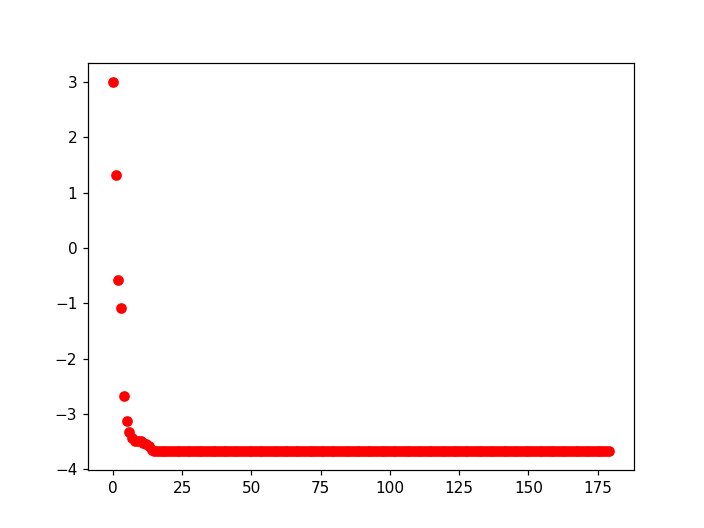

In [117]:
%matplotlib notebook
plt.plot(range(len(Heff.energies)),Heff.energies,"or")

In [103]:
import tenTools
reload(tenTools)
t=tenTools.timer()
t.toogle()
a=0
for i in range(1000):
    a+=1
t.toogle()
t

<elaps=0.0002869020026992075>

In [115]:
1786*9*10/(60*60)

44.65